# Final project: BMEN 619.18 (MDSC 689.03) Advanced Medical Image Processing 
## Topic: Face Recognition 

This project aims to compare the performance of Support Vector Machines (SVM), and k-Nearest Neighbours (KNN) algorithms in recognizing faces. The Local Binary Patterns (LBP) descriptor is employed to extract features due to its computational efficiency, robustness to monotonic grayscale changes.

## Dataset: https://www.kaggle.com/datasets/kasikrit/att-database-of-faces
The input database for this project was chosen to be the AT&T dataset, which includes grayscale images of 40 individuals with 10 images per individual. Since the AT&T dataset comprises images that are already cropped to show only the face, further face-detection steps were considered unnecessary. Although the images have a uniform size of 92x112 pixels and 256 grey levels per pixel, they vary in angles, expressions, and lighting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import scipy.linalg as la
from sklearn.neighbors import KNeighborsClassifier
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
import matplotlib
matplotlib.rc('image', cmap='gray')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import itertools
import cv2

In [ ]:
# Function to extract features from the dataset using Local Binary Patterns (LBP)

def feature_extraction (dataset):
    P = 12 # Number of circularly symmetric neighbor
    Q = 4 # Radius of circle
    lbp =[] 
    for i in range(0, len(DataA)):
        lbp.append(feature.local_binary_pattern(dataset[i], P, Q))
    
    hist_lbp = [] # list of feature vectors 
    for i in range(0, int(len(lbp))):
        n_bins = int(lbp[i].max() + 1)
        hist, bins = np.histogram(lbp[i], bins=n_bins, range=(0, n_bins))
        hist_lbp.append(hist)
    print("The number of feature vectors are: " + str(len(hist_lbp)))
    
    return hist_lbp


# Function to evaluate the prediction results using metrics like TPR, TNR, FPR, and FNR
def prediction_evaluation(predicted_label, true_label):
    TP, FP, TN, FN = 0, 0, 0, 0
    for subject_id in range (1, 41):
        for predictedLabel, realLabel in zip(predicted_label, true_label):
            if predictedLabel == subject_id and realLabel == subject_id:
                TP += 1
            if predictedLabel != subject_id and realLabel == subject_id:
                FN += 1
            if predictedLabel != subject_id and realLabel != subject_id:
                TN += 1
            if predictedLabel == subject_id and realLabel != subject_id:
                FP += 1
    #print("TP: %d, FP: %d, TN: %d, FN: %d" % (TP, FP, TN, FN))
    # Recall
    TPR = TP / (TP + FN)
    # Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate
    FPR = FP / (FP + TN)
    # False Negative Rate
    FNR = FN / (TP + FN)
    print("TPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100,FPR*100, FNR*100))
    

def plot_confusion_matrix(cm, target_names):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix\nAccuracy: {:0.4f}'.format(accuracy))
    plt.colorbar(fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, "{:,}".format(cm[i, j]), color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

In this project, the dataset is divided into two distinct groups, namely A and B, with each group consisting of 5 images from each individual. The evaluation of the model is based on 2-fold cross-validation, where each subset A and B is alternately used for training and testing.

In [3]:
#DATABASE CREATION
N_SUBJECTS = 40;
N_IMAGES = 10;
N_SET = 5;

#Data and lable 
DataA = [];
DataB = [];

LableA = [];
LableB = [];

for subjectID in range(1, N_SUBJECTS + 1):
    for imageID in range(1, N_IMAGES + 1):
        
        img = cv2.imread("./ATT dataset/s%d/%d.pgm" %(subjectID, imageID), cv2.IMREAD_GRAYSCALE);
        
        if imageID <= N_SET:
            DataA.append(img);
            LableA.append(subjectID);
        else:
            DataB.append(img);
            LableB.append(subjectID);        
        

A normalization process has been implemented to standardize the intensity values of the grayscale image dataset utilized in this project. The process involves a linear transformation of the input image $I$, which has intensity values within the range ${Min, Max}$, to a new image $Inew$, which has intensity values within the range ${newMin, newMax}$. This normalization step is the only preprocessing step required for the dataset.

In [4]:
#IMAGE PREPROCESSING
NEW_MIN = 0;
NEW_MAX = 255;

for i in range(0, N_SUBJECTS*N_SET):
    img = DataA[i];
    cur_min = np.amin(img);
    cur_max = np.amax(img);
    
    img = img - cur_min;
    img = img*((NEW_MAX - NEW_MIN)/(cur_max - cur_min));
    img = img + NEW_MIN;
    
    DataA[i] = img;
    
for i in range(0, N_SUBJECTS*N_SET):
    img = DataB[i];
    cur_min = np.amin(img);
    cur_max = np.amax(img);
    
    img = img - cur_min;
    img = img*((NEW_MAX - NEW_MIN)/(cur_max - cur_min));
    img = img + NEW_MIN;
    
    DataB[i] = img;

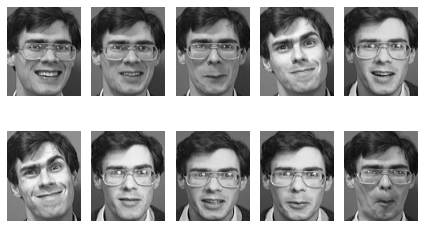

In [5]:
#plt.figure(figsize=(5,5))
#plt.suptitle("Subject 20 Images", weight='bold')
for i in range(1,11):
    img = imread('./ATT dataset/s20/' + '{}.pgm'.format(i), as_gray=True)
    plt.subplot(2,5,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

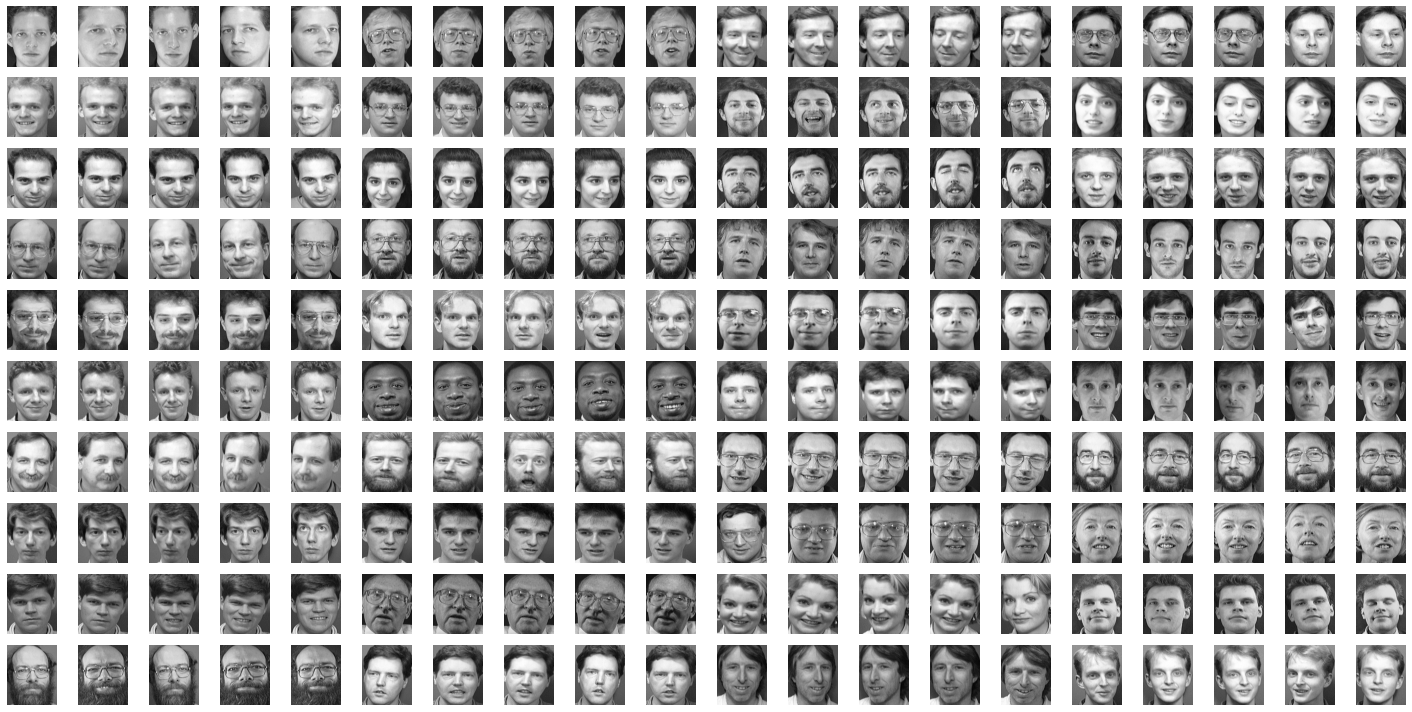

In [6]:
#DISPLAYING IMAGE DATABASE A
plt.figure(figsize=(20, 10))
for i in range(1, N_SUBJECTS*N_SET + 1):
    img = DataA[i - 1]
    
    plt.subplot(int(N_SUBJECTS/4), int(N_SET*4), i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

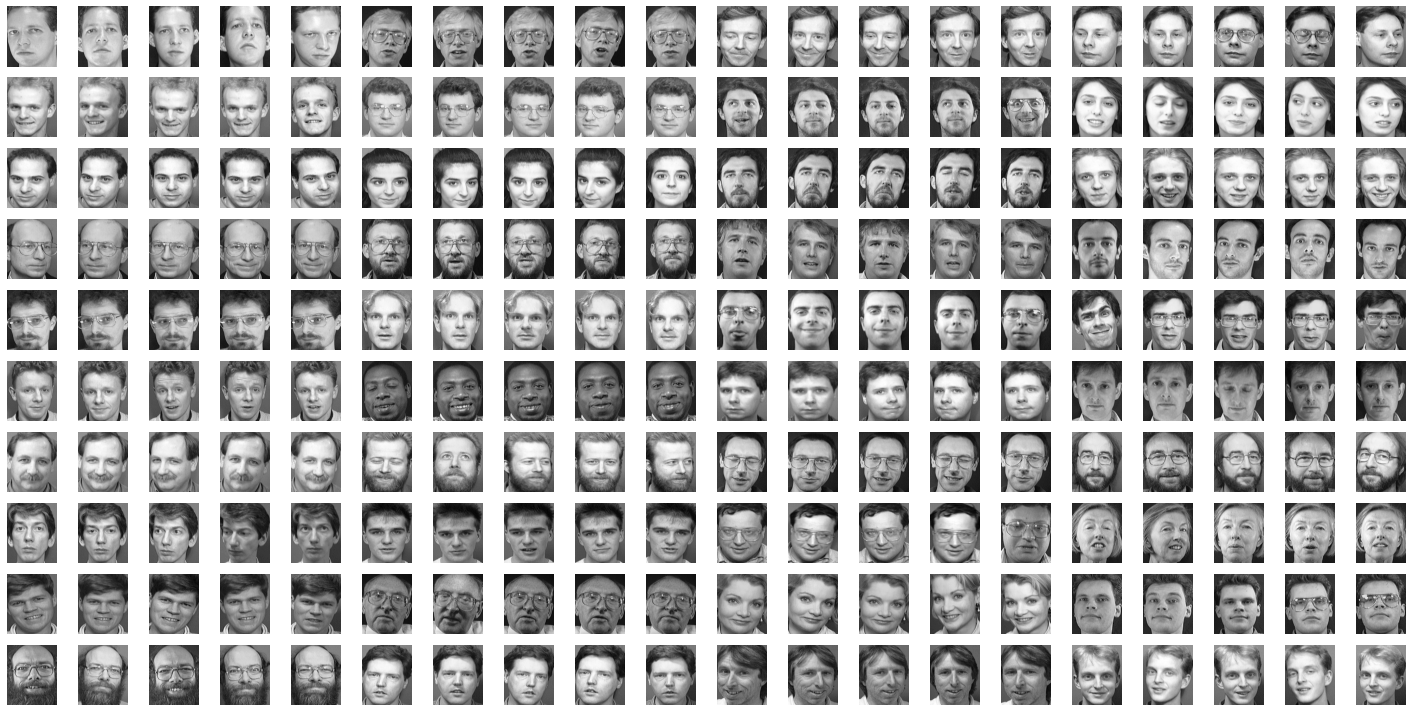

In [7]:
#DISPLAYING IMAGE DATABASE B
plt.figure(figsize=(20, 10))
for i in range(1, N_SUBJECTS*N_SET + 1):
    img = DataB[i - 1]
    
    plt.subplot(int(N_SUBJECTS/4), int(N_SET*4), i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

## Calculate LBP and histogram for datasets

The LBP algorithm is the most widely used method for feature extraction in face recognition. It is a texture analysis approach that captures the local texture patterns of an image by comparing the pixel values of the central pixel with its surrounding neighbours. 

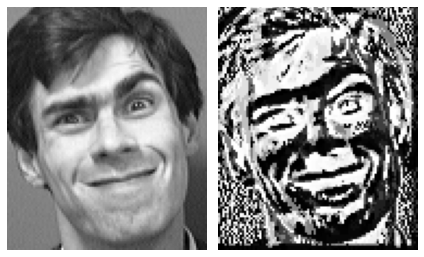

In [8]:
#code for presentation (visualisastion)
img = DataB[95];
lbp_img = feature.local_binary_pattern(DataB[95], 12, 4)
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray');
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(lbp_img, cmap='gray');
plt.axis('off');

In [9]:
hist_lbp_A = feature_extraction (DataA)
hist_lbp_B = feature_extraction (DataB)

The number of feature vectors are: 200
The number of feature vectors are: 200


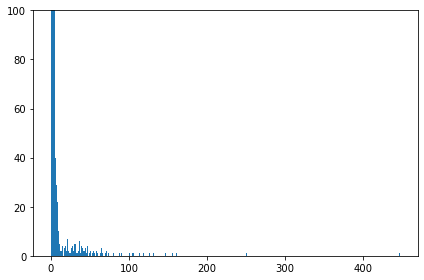

447


In [10]:
# plotting feature vector at index 11 for illustrative purposes
n_bins = int(hist_lbp_A[10].max() + 1)
plt.ylim([0, 100])
plt.hist(hist_lbp_A[10].ravel(), bins=n_bins, range=(0, n_bins))
plt.show()
print (n_bins)

## SVM classifier

The SVM classifier has three parameters: kernel function, C parameter, and gamma parameter. Our objective is to determine the optimal values for these parameters to separate classes within the SVM effectively.

In [16]:
svc_param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'gamma': [1, 0.1, 0.01, 0.001]}
svc = SVC()

clf = GridSearchCV(svc, svc_param_grid, verbose=2, cv=3)
clf.fit(hist_lbp_A, LableA)
print('The optimal parameters are: ' + str(clf.best_estimator_))
grid_predictions = clf.predict(hist_lbp_B)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, 

[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       0.50      0.80      0.62         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00      1.00      1.00         5
          18       1.00    

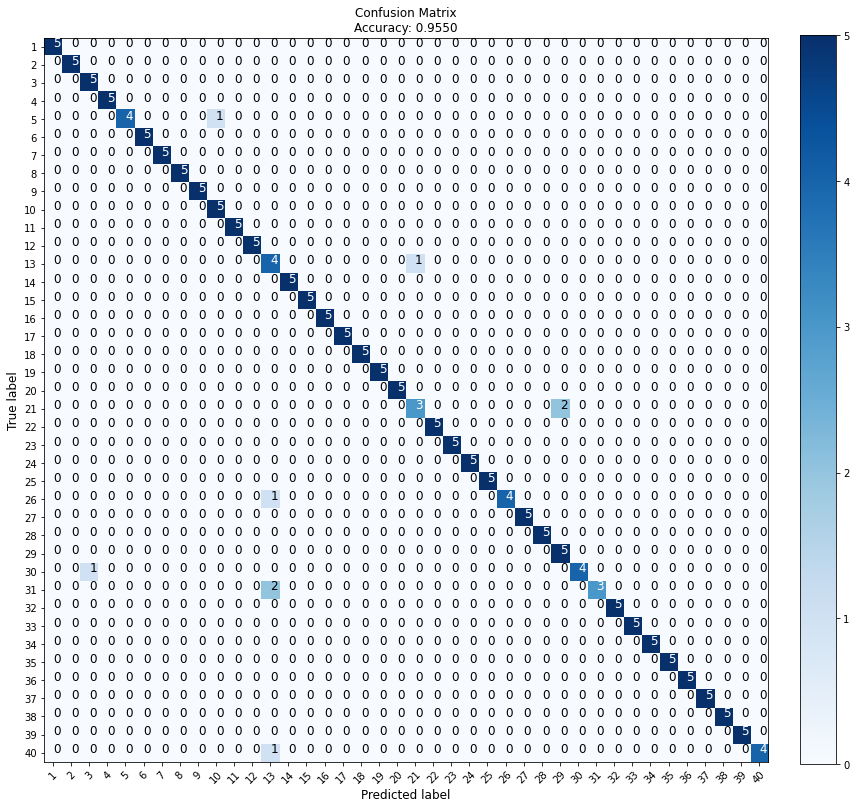

In [17]:
print(classification_report(LableB,grid_predictions)) # generate classification  report based on predictions
prediction_evaluation(grid_predictions, LableB) # calculate and display accuracy metrics
confusionMatrix = confusion_matrix(LableB, grid_predictions) # generate the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,target_names = [i for i in range(1, N_SUBJECTS+1)])


In [21]:
for i in range(len(hist_lbp_B)):
    print("Image ", (i+1)/5)
    print("Predicted label: ", grid_predictions[i])
    print("Ground truth label: ", LableB[i])
    print("------------------------")

Image  0.2
Predicted label:  1
Ground truth label:  1
------------------------
Image  0.4
Predicted label:  1
Ground truth label:  1
------------------------
Image  0.6
Predicted label:  1
Ground truth label:  1
------------------------
Image  0.8
Predicted label:  1
Ground truth label:  1
------------------------
Image  1.0
Predicted label:  1
Ground truth label:  1
------------------------
Image  1.2
Predicted label:  2
Ground truth label:  2
------------------------
Image  1.4
Predicted label:  2
Ground truth label:  2
------------------------
Image  1.6
Predicted label:  2
Ground truth label:  2
------------------------
Image  1.8
Predicted label:  2
Ground truth label:  2
------------------------
Image  2.0
Predicted label:  2
Ground truth label:  2
------------------------
Image  2.2
Predicted label:  3
Ground truth label:  3
------------------------
Image  2.4
Predicted label:  3
Ground truth label:  3
------------------------
Image  2.6
Predicted label:  3
Ground truth label:  

Ground truth label:  31
------------------------
Image  31.0
Predicted label:  31
Ground truth label:  31
------------------------
Image  31.2
Predicted label:  32
Ground truth label:  32
------------------------
Image  31.4
Predicted label:  32
Ground truth label:  32
------------------------
Image  31.6
Predicted label:  32
Ground truth label:  32
------------------------
Image  31.8
Predicted label:  32
Ground truth label:  32
------------------------
Image  32.0
Predicted label:  32
Ground truth label:  32
------------------------
Image  32.2
Predicted label:  33
Ground truth label:  33
------------------------
Image  32.4
Predicted label:  33
Ground truth label:  33
------------------------
Image  32.6
Predicted label:  33
Ground truth label:  33
------------------------
Image  32.8
Predicted label:  33
Ground truth label:  33
------------------------
Image  33.0
Predicted label:  33
Ground truth label:  33
------------------------
Image  33.2
Predicted label:  34
Ground truth lab

In [14]:
svc_param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'gamma': [1, 0.1, 0.01, 0.001]}
svc = SVC()
clf = GridSearchCV(svc, svc_param_grid, verbose=2, cv=3) # change to verbose=0      if you do not want to see training steps
clf.fit(hist_lbp_B, LableB)
print('The optimal parameters are: ' + str(clf.best_estimator_))
grid_predictions = clf.predict(hist_lbp_A) # predictions made using testing set


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, 

[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.60      0.75         5
           4       0.83      1.00      0.91         5
           5       1.00      0.80      0.89         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.71      1.00      0.83         5
          13       0.75      0.60      0.67         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.75      0.60      0.67         5
          17       1.00      0.60      0.75         5
          18       0.83    

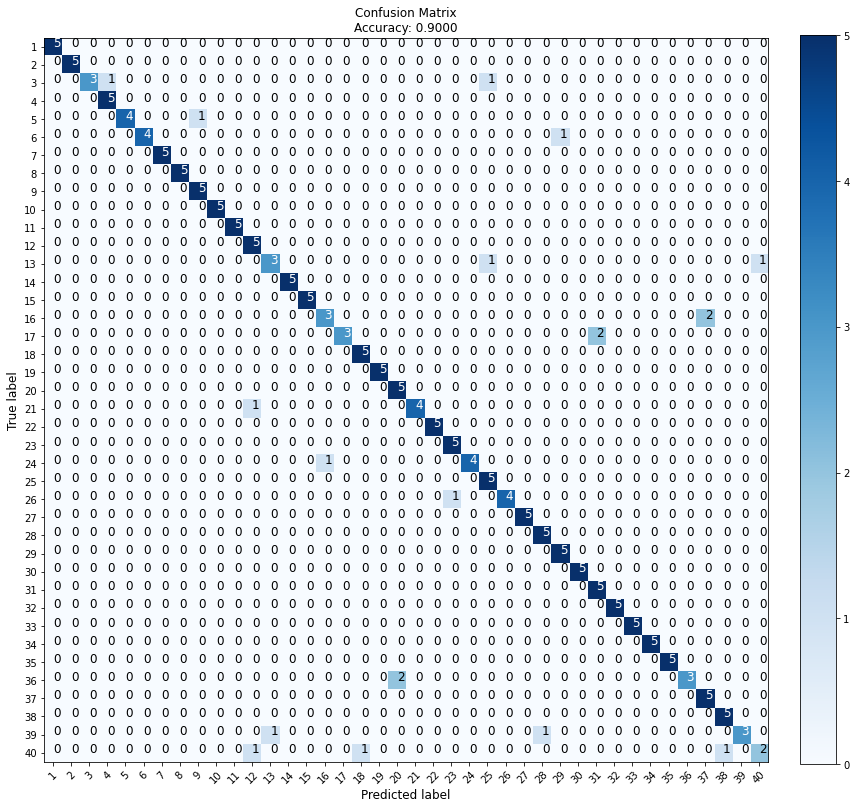

In [15]:
print(classification_report(LableA,grid_predictions)) # generate classification  report based on predictions
prediction_evaluation(grid_predictions, LableA) # calculate and display accuracy metrics
confusionMatrix = confusion_matrix(LableA, grid_predictions) # generate the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,target_names = [i for i in range(1, N_SUBJECTS+1)])

## KNN classifier

In [16]:
knn_param_grid = {'n_neighbors':[2, 3, 5, 8, 11, 15, 18, 21, 25]}
knn = KNeighborsClassifier()

clf = GridSearchCV(knn, knn_param_grid, verbose=2, cv=3) # change to verbose=0      if you do not want to see training steps
clf.fit(hist_lbp_A, LableA)
print('The optimal parameters are: ' + str(clf.best_estimator_))
grid_predictions = clf.predict(hist_lbp_B) # predictions made using testing set



Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=8; total time=   0.0s
[CV] END ......................................n_neighbors=8; total time=   0.0s
[CV] END ......................................n_

D:\Programs\anaconda\envs\laba\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\anaconda\envs\laba\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\anaconda\envs\laba\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.50      1.00      0.67         5
           4       0.67      0.80      0.73         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       0.71      1.00      0.83         5
           8       1.00      1.00      1.00         5
           9       0.42      1.00      0.59         5
          10       0.44      0.80      0.57         5
          11       1.00      1.00      1.00         5
          12       0.60      0.60      0.60         5
          13       0.57      0.80      0.67         5
          14       0.56      1.00      0.71         5
          15       1.00      1.00      1.00         5
          16       0.80      0.80      0.80         5
          17       0.80      0.80      0.80         5
          18       0.75    

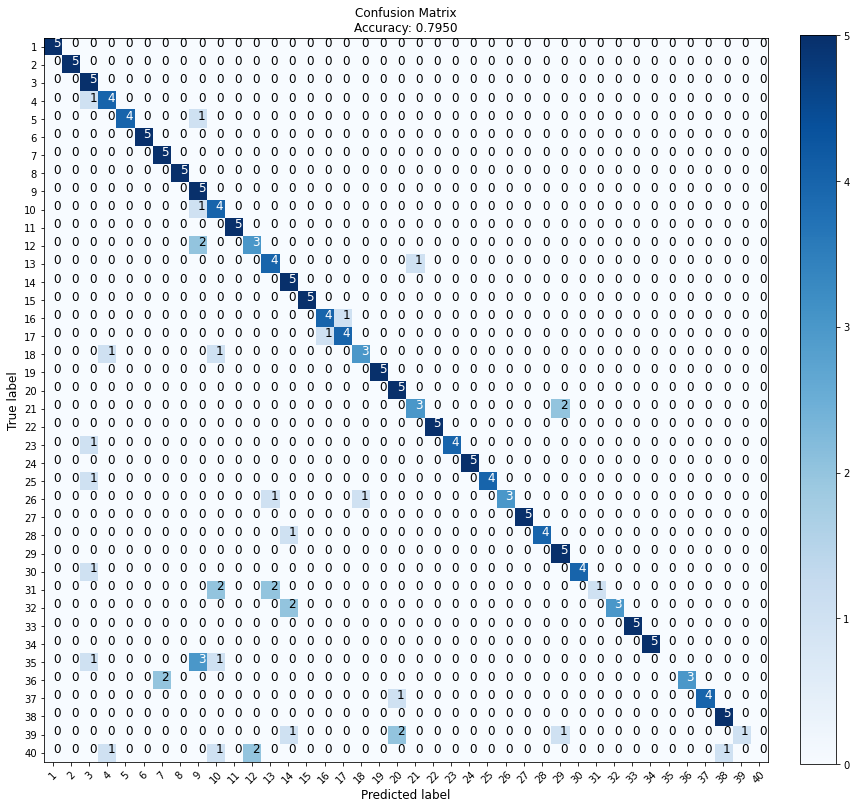

In [17]:
print(classification_report(LableB,grid_predictions)) # generate classification  report based on predictions
prediction_evaluation(grid_predictions, LableB) # calculate and display accuracy metrics
confusionMatrix = confusion_matrix(LableB, grid_predictions) # generate the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,target_names = [i for i in range(1, N_SUBJECTS+1)])

In [18]:
knn_param_grid = {'n_neighbors':[2, 3, 5, 8, 11, 15, 18, 21, 25]}
knn = KNeighborsClassifier()

clf = GridSearchCV(knn, knn_param_grid, verbose=2, cv=3) # change to verbose=0      if you do not want to see training steps
clf.fit(hist_lbp_B, LableB)
print('The optimal parameters are: ' + str(clf.best_estimator_))
grid_predictions = clf.predict(hist_lbp_A) # predictions made using testing set


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=8; total time=   0.0s
[CV] END ......................................n_neighbors=8; total time=   0.0s
[CV] END ......................................n_

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      0.60      0.75         5
           4       0.62      1.00      0.77         5
           5       1.00      0.60      0.75         5
           6       1.00      0.80      0.89         5
           7       0.71      1.00      0.83         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.50      1.00      0.67         5
          13       0.67      0.40      0.50         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.67      0.40      0.50         5
          17       1.00      0.60      0.75         5
          18       0.50    

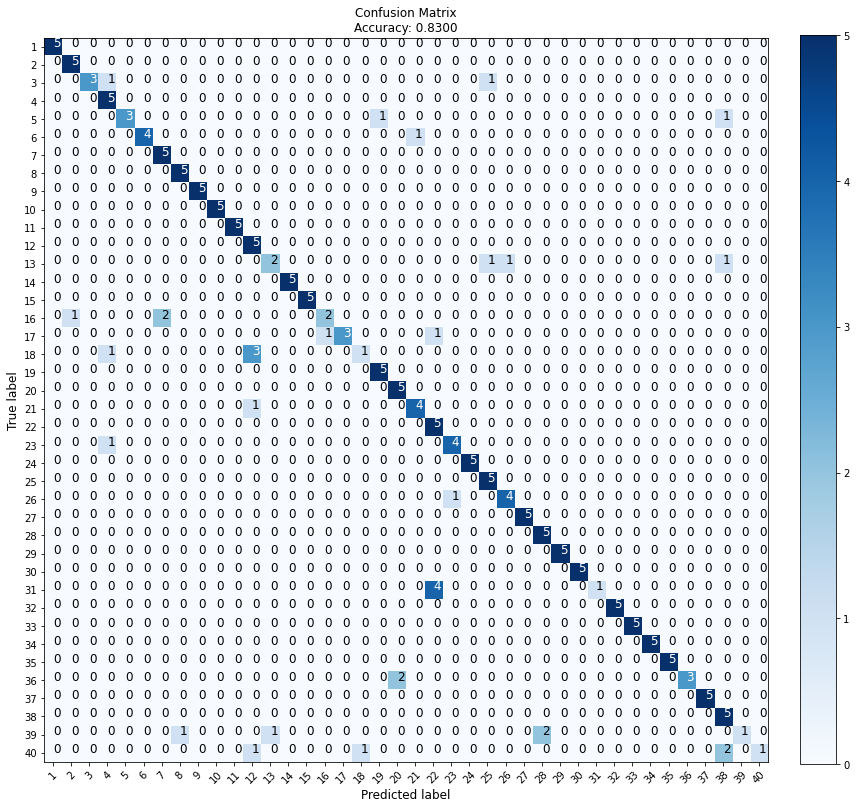

In [19]:
print(classification_report(LableA,grid_predictions)) # generate classification  report based on predictions

prediction_evaluation(grid_predictions, LableA) # calculate and display accuracy metrics
confusionMatrix = confusion_matrix(LableB, grid_predictions) # generate the confusion matrix
plot_confusion_matrix(cm=confusionMatrix,target_names = [i for i in range(1, N_SUBJECTS+1)])

# Conclusion

Four classifiers are compared, namely SVM-AB, KNN-AB, SVM-BA, and KNN-BA. The SVM-AB and KNN-AB classifiers were trained using the A-group and tested using the B-group, whereas the SVM-BA and KNN-BA classifiers were trained using the B-group and tested using the A-group. The performance of each fold is evaluated by measuring accuracy, FAR, and FRR. 

An effective facial recognition model should have high accuracy and low FPR and FNR, indicating that it can accurately classify data into their respective classes while minimizing the number of false predictions.

### Table: Performance of the Face Recognition Classifiers

| **Method**  | **Accuracy (%)** | **FPR (%)** | **FNR (%)** |
|-------------|------------------|-------------|-------------|
| SVM-AB      | **95**           | **0.12**    | **4.5**     |
| SVM-BA      | 90               | 0.26        | 10          |
| KNN-AB      | 79               | 0.53        | 20.5        |
| KNN-BA      | 83               | 0.44        | 17          |


- Based on the results of the four classifiers, it can be concluded that SVM-AB and SVM-BA have the highest accuracy scores, with 95% and 90%, respectively. Both classifiers have relatively low FPR. However, the FNR of SVM-BA is higher than SVM-AB, with 10% compared to 4.5%.

- KNN-AB and KNN-BA have lower accuracy scores compared to SVM. Also, both KNNs have a relatively high FPR and FPR. 

- SVM-AB is the best classifier for accuracy and false positive rate while maintaining a relatively low false negative rate. This indicates that SVM-AB can correctly classify a high percentage of the face images in the test set while minimizing false positives. This is particularly important in applications where false positives can have serious consequences, such as security systems. 